<a href="https://colab.research.google.com/github/blakeobeans/kaggle_notebooks/blob/master/Titanic_w_XGB_before_xgbmods.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import matplotlib.pyplot as plt

### Mount Google Drive

In [2]:
from google.colab import drive
import os
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
#set wd
path = '/content/drive/My Drive/Colab Notebooks/Kaggle/Titanic'
os.chdir(path)
path

'/content/drive/My Drive/Colab Notebooks/Kaggle/Titanic'

In [0]:
from google.colab import files

### Set API Creds

In [0]:
import os
os.environ['KAGGLE_USERNAME'] = "blakeobeans"

In [0]:
os.environ['KAGGLE_KEY'] = "60017706bdc00c3f8b75bdd75f4331b0"

### Download Data

In [7]:
!kaggle competitions download -c titanic

test.csv: Skipping, found more recently modified local copy (use --force to force download)
train.csv: Skipping, found more recently modified local copy (use --force to force download)
gender_submission.csv: Skipping, found more recently modified local copy (use --force to force download)


### Import Data

In [0]:
import pandas as pd

In [0]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

## Exploratory Analysis

In [10]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [11]:
train.shape

(891, 12)

In [12]:
test.shape

(418, 11)

## Feature Engineering

### Data Concatenation

In [0]:
train_labels = train['Survived'] #resume working with labels in section  "Splitting Data"

In [0]:
train = train.drop(['Survived'], axis = 1)

In [0]:
df = pd.concat([train, test], axis = 0)

In [16]:
df.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


### Remove irrelevant variables

In [0]:
#Removing 'PassengerID'
df = df.drop(['PassengerId'], axis = 1)

### Missing Data Imputation

In [18]:
df.isna().sum()

Pclass         0
Name           0
Sex            0
Age          263
SibSp          0
Parch          0
Ticket         0
Fare           1
Cabin       1014
Embarked       2
dtype: int64

Missing data for age, fare, cabin and embarked.

In [19]:
df.corr()

,Pclass,Age,SibSp,Parch,Fare
Pclass,1.000000,-0.408106,0.060832,0.018322,-0.558629
Age,-0.408106,1.000000,-0.243699,-0.150917,0.178740
SibSp,0.060832,-0.243699,1.000000,0.373587,0.160238
Parch,0.018322,-0.150917,0.373587,1.000000,0.221539
Fare,-0.558629,0.178740,0.160238,0.221539,1.000000


#### 'Age'

Age is most closely correlated with Pclass and SibSp, so we'll impute after grouping by these two variables.

In [0]:
#df.groupby(['Pclass', 'SibSp']).median()['Age']
df['Age'] = df.groupby(['Pclass', 'SibSp'])['Age'].transform(lambda x: x.fillna(x.median()))

#### 'Embarked'

In [0]:
#Googling identifies passenger by name- departed from Southampton
df['Embarked'] = df['Embarked'].fillna('S')

#### 'Fare'

In [22]:
df[df['Fare'].isnull()]

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
152,3,"Storey, Mr. Thomas",male,60.5,0,0,3701,NaN,NaN,S


In [0]:
#most closely correlated with Pclass, Parch and Age
#group by Pclass only because no match for Parch and Age
df.groupby(['Pclass', 'Parch', 'Age']).median()['Fare']
df['Fare'] = df.groupby(['Pclass'])['Fare'].transform(lambda x: x.fillna(x.median()))

#### 'Cabin'

In [0]:
#create a deck column from the first letter of the cabin column
df['Deck'] = df['Cabin'].apply(lambda s: s[0] if pd.notnull(s) else 'M')

In [0]:
df['Deck'] = df['Deck'].replace(['A', 'B', 'C', 'T'], 'ABC')
df['Deck'] = df['Deck'].replace(['D', 'E'], 'DE')
df['Deck'] = df['Deck'].replace(['F', 'G'], 'FG')

In [0]:
df = df.drop(['Cabin'], axis = 1)

### Frequency Encoding

#### 'Family Size'

In [0]:
df['Family_Size'] = df['SibSp'] + df['Parch'] + 1

#### 'Ticket Frequency'

In [0]:
df['Ticket_Frequency'] = df.groupby('Ticket')['Ticket'].transform('count')

#### 'Is_Married' (woman only)

In [31]:
df['Title'] = df['Name'].str.split(', ', expand=True)[1].str.split('.', expand=True)[0]
df['Is_Married'] = 0
df['Is_Married'].loc[df['Title'] == 'Mrs'] = 1

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


#### 'Title'

In [0]:
df['Title'] = df['Title'].replace(['Miss', 'Mrs','Ms', 'Mlle', 'Lady', 'Mme', 'the Countess', 'Dona'], 'Miss/Mrs/Ms')
df['Title'] = df['Title'].replace(['Dr', 'Col', 'Major', 'Jonkheer', 'Capt', 'Sir', 'Don', 'Rev'], 'Dr/Military/Noble/Clergy')

### Categorical Encoding

Because the XGBoost algorithm requires numeric value, we have to main options for dealing with categorical variables: **label encoding** and **one-hot encoding**.  
I'll opt for label encoding where there is an inherent rank and one-hot encoding otherwise.

In [32]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 0 to 417
Data columns (total 14 columns):
Pclass              1309 non-null int64
Name                1309 non-null object
Sex                 1309 non-null object
Age                 1309 non-null float64
SibSp               1309 non-null int64
Parch               1309 non-null int64
Ticket              1309 non-null object
Fare                1309 non-null float64
Embarked            1309 non-null object
Deck                1309 non-null object
Family_Size         1309 non-null int64
Ticket_Frequency    1309 non-null int64
Title               1309 non-null object
Is_Married          1309 non-null int64
dtypes: float64(2), int64(6), object(6)
memory usage: 153.4+ KB


**Label encoding**: Pclass  
**One-hot encoding**: Sex, Embarked

In [0]:
df_cat_ohe = df[['Sex', 'Embarked', 'Deck']]
df_cat_le = df[['Pclass']]
df_quant = df[['Age', 'SibSp', 'Parch', 'Fare']]

#### Label Encoding

Label encoding can be done with pandas

In [0]:
df_cat_le['Pclass'] = pd.to_numeric(df_cat_le['Pclass']) # Replace strings with an integer

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


#### One-hot encoding

In [0]:
df_cat_ohe.Sex.unique()

array(['male', 'female'], dtype=object)

In [0]:
df_cat_ohe.Embarked.unique()

array(['S', 'C', 'Q'], dtype=object)

In [0]:
df_cat_ohe.Deck.unique()

array(['M', 'ABC', 'DE', 'FG'], dtype=object)

In [0]:
from sklearn import preprocessing

In [0]:
enc = preprocessing.OneHotEncoder()
enc.fit(df_cat_ohe)
onehotlabels = enc.transform(df_cat_ohe).toarray()
df_ohe = pd.DataFrame(onehotlabels)
df_ohe.columns = ['M', 'F', 'S', 'C', 'Q', 'D_M', 'D_ABC', 'D_E', 'D_FG']

### Ticket and Name- To Be Continued

### Joining Data Frame

In [0]:
df = pd.concat([df_quant, df_cat_le], axis=1, sort=False)

In [0]:
df = df.reset_index(drop = False)

In [0]:
df_ohe = df_ohe.reset_index(drop = False)

In [0]:
df = df.join(df_ohe.set_index('index'), on = 'index')

In [0]:
df = df.drop(['index'], axis = 1)

## Splitting Data

### Train and Test Set

In [0]:
train_features = df.iloc[0:890,:]
test_features = df.iloc[891:1310,:]

In [0]:
train_features.shape

(890, 14)

In [0]:
test_features.shape

(418, 14)

In [0]:
train = pd.concat([train_features, train_labels], axis=1, sort=False)

### Validation Data for Cross-Validation

In [0]:
from sklearn.model_selection import train_test_split

In [0]:
split_percent = 0.3
train, val = train_test_split(train, test_size=split_percent, stratify = train['Survived'], random_state=42) 

In [0]:
train_labels = train['Survived']
val_labels = val['Survived']

In [0]:
train_features = train.drop('Survived', axis = 1)
val_features = val.drop('Survived', axis = 1)

## XGBoost with Scikit-Learn API

In [0]:
import xgboost as xgb

### Grid Search w/ Cross Validation

The XGBoost library does not have a grid search function, so we will use the scikit-learn API for XGBoost instead. 

In [0]:
from sklearn.model_selection import GridSearchCV

In [0]:
cv_params = {
     'min_child_weight': [1, 3, 5], #weight required for new node
     'gamma': [0.5, 1, 1.5, 2, 5],
     'subsample': [0.6, 0.8, 1.0], #fraction of rows to subsample
     'colsample_bytree': [0.6, 0.8, 1.0], #fraction of features to use
     'max_depth': [3, 4, 5], #number of allowable nodes
}

#     'n_estimators':[50, 75, 100],
#     'learning_rate': [0.01, 0.05, 0.1],

In [0]:
ind_params = {'seed':0, 
              'objective': 'binary:logistic'}

In [0]:
folds = 5
param_comb = 5
skf = StratifiedKFold(n_splits = folds, 
                      shuffle = True, 
                      random_state = 1001)

In [0]:
random_search = RandomizedSearchCV

In [0]:
#XGBclassifier within grid search function
optimized_GBM = GridSearchCV(estimator = xgb.XGBClassifier(**ind_params), 
                             param_grid= cv_params, 
                             scoring = 'accuracy', 
                             cv = 5, #5 folds
                             n_jobs = -1,  #use all processors
                             verbose = 1)

In [0]:
#trained with the evaluation set to prevent overfitting
optimized_GBM.fit(X = train_features, 
                  y = train_labels,
                  eval_set = [(val_features, val_labels)],
                  eval_metric = "error",
                  early_stopping_rounds = 25)

Fitting 5 folds for each of 729 candidates, totalling 3645 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 164 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done 764 tasks      | elapsed:   23.6s
[Parallel(n_jobs=-1)]: Done 1764 tasks      | elapsed:   54.5s
[Parallel(n_jobs=-1)]: Done 3164 tasks      | elapsed:  1.6min


[0]	validation_0-error:0.205224
Will train until validation_0-error hasn't improved in 25 rounds.
[1]	validation_0-error:0.235075
[2]	validation_0-error:0.242537
[3]	validation_0-error:0.227612
[4]	validation_0-error:0.253731
[5]	validation_0-error:0.216418
[6]	validation_0-error:0.201493
[7]	validation_0-error:0.208955
[8]	validation_0-error:0.223881
[9]	validation_0-error:0.205224
[10]	validation_0-error:0.197761
[11]	validation_0-error:0.190299
[12]	validation_0-error:0.19403
[13]	validation_0-error:0.182836
[14]	validation_0-error:0.186567
[15]	validation_0-error:0.182836
[16]	validation_0-error:0.182836
[17]	validation_0-error:0.186567
[18]	validation_0-error:0.179104
[19]	validation_0-error:0.175373
[20]	validation_0-error:0.171642
[21]	validation_0-error:0.171642
[22]	validation_0-error:0.182836
[23]	validation_0-error:0.179104
[24]	validation_0-error:0.182836
[25]	validation_0-error:0.175373
[26]	validation_0-error:0.175373
[27]	validation_0-error:0.186567
[28]	validation_0-err

[Parallel(n_jobs=-1)]: Done 3645 out of 3645 | elapsed:  1.9min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=3, min_child_weight=1,
                                     missing=None, n_estimators=100, n_jobs=1,
                                     nthread=None, objective='binary:logistic',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=0, silent=None,
                                     subsample=1, verbosity=1),
             iid='deprecated', n_jobs=-1,
             param_grid={'colsample_bytree': [0.2, 0.3, 0.4],
                         'learning_rate': [0.01, 0.05, 0.1],
                         'max_depth': [2, 3, 4], 'min_child

### Reviewing Grid Scores

All of the hyperparameters are at their minimum. We're surely overfitting.

In [0]:
pd.DataFrame(optimized_GBM.cv_results_['params']).head()

,colsample_bytree,learning_rate,max_depth,min_child_weight,n_estimators,subsample
0,0.2,0.01,2,1,50,0.3
1,0.2,0.01,2,1,50,0.4
2,0.2,0.01,2,1,50,0.5
3,0.2,0.01,2,1,75,0.3
4,0.2,0.01,2,1,75,0.4


### Tuning Hyperparameters

If the optimum hyperparameter is on a lower or upper bound, include smaller/larger parameters and search again. (Just adjust the grid search parameters in the previous section.)

### Picking Best Parameters

In [0]:
params = optimized_GBM.best_params_

In [0]:
params['seed'] = 0
params['objective'] = 'binary:logistic'  

## XGBoost with XGBoost API

### Create Dataset

In [0]:
dtrain = xgb.DMatrix(train_features, label=train_labels)
dval = xgb.DMatrix(val_features, label=val_labels)
dtest = xgb.DMatrix(test_features)

/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


### Set number of trees

In [0]:
cv_xgb = xgb.cv(params = params, 
                dtrain = dtrain, 
                num_boost_round = 3000, #number of trees to build
                nfold = 5,
                metrics = ['error'], 
                early_stopping_rounds = 100) # Look for early stopping that minimizes error

In [0]:
cv_xgb.tail()

,train-error-mean,train-error-std,test-error-mean,test-error-std
100,0.120785,0.008228,0.179794,0.025721
101,0.120382,0.008837,0.182981,0.023359
102,0.120784,0.009407,0.179781,0.026125
103,0.119981,0.009814,0.178155,0.030024
104,0.119177,0.008786,0.173355,0.025105


### Training Model

In [0]:
bst = xgb.train(params, 
                dtrain, 
                evals = [(dval, "Validation")],
                early_stopping_rounds = 10, #this has an effect
                num_boost_round = 104)

[0]	Validation-error:0.205224
Will train until Validation-error hasn't improved in 10 rounds.
[1]	Validation-error:0.235075
[2]	Validation-error:0.242537
[3]	Validation-error:0.227612
[4]	Validation-error:0.253731
[5]	Validation-error:0.216418
[6]	Validation-error:0.201493
[7]	Validation-error:0.208955
[8]	Validation-error:0.223881
[9]	Validation-error:0.205224
[10]	Validation-error:0.197761
[11]	Validation-error:0.190299
[12]	Validation-error:0.19403
[13]	Validation-error:0.182836
[14]	Validation-error:0.186567
[15]	Validation-error:0.182836
[16]	Validation-error:0.182836
[17]	Validation-error:0.186567
[18]	Validation-error:0.179104
[19]	Validation-error:0.175373
[20]	Validation-error:0.171642
[21]	Validation-error:0.171642
[22]	Validation-error:0.182836
[23]	Validation-error:0.179104
[24]	Validation-error:0.182836
[25]	Validation-error:0.175373
[26]	Validation-error:0.175373
[27]	Validation-error:0.186567
[28]	Validation-error:0.179104
[29]	Validation-error:0.179104
[30]	Validation-e

## Analyze Model

### Importance Plot

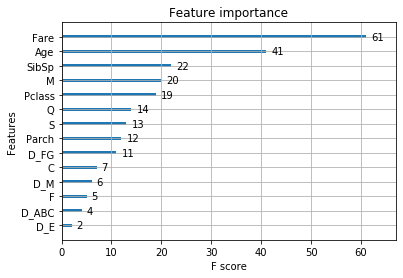

In [0]:
xgb.plot_importance(bst)

### Tree Plot

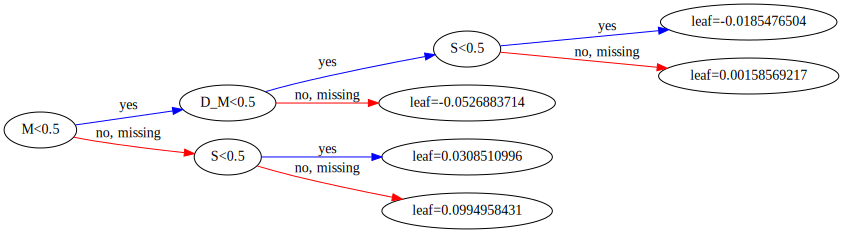

In [0]:
xgb.to_graphviz(bst, num_trees=20, rankdir='LR')

### ROC Curve/Threshold

In [0]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

In [0]:
lr_probs = bst.predict(dval)

In [0]:
# generate a no skill prediction (majority class)
ns_probs = [0 for _ in range(len(val_labels))]

In [0]:
# calculate scores
ns_auc = roc_auc_score(val_labels, ns_probs)
lr_auc = roc_auc_score(val_labels, lr_probs)

In [0]:
# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('XGBoost: ROC AUC=%.3f' % (lr_auc))

No Skill: ROC AUC=0.500
XGBoost: ROC AUC=0.858


In [0]:
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(val_labels, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(val_labels, lr_probs)

In [0]:
from matplotlib import pyplot

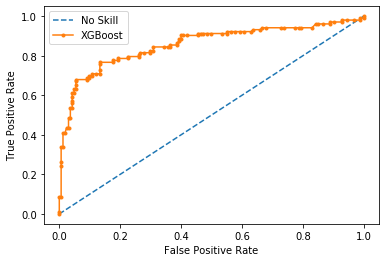

In [0]:
# plot the roc curve for the model
pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
pyplot.plot(lr_fpr, lr_tpr, marker='.', label='XGBoost')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

## Making Predictions

In [0]:
y_pred = bst.predict(dtest)

In [0]:
y_pred.shape

(418,)

In [0]:
import numpy as np

In [0]:
y_pred = np.where(y_pred > 0.9, 1, 0)
y_pred = np.asarray(y_pred)

In [0]:
test = pd.read_csv('test.csv')

In [0]:
submission = pd.DataFrame(
    {"PassengerID": test.iloc[:,0],
     "Survived": y_pred}
)

### Saving Predictions

In [0]:
from numpy import asarray
from numpy import savetxt
savetxt('submission_16.csv', submission, delimiter=',') # save to csv file
submission.to_csv("submission_16.csv", index = False)

### Submitting via Kaggle API

In [0]:
!kaggle competitions submit -c titanic -f submission_16.csv -m 'playing with label thresholds'

100% 2.77k/2.77k [00:05<00:00, 564B/s]
Successfully submitted to Titanic: Machine Learning from Disaster

In [0]:
!kaggle competitions submissions -c titanic

fileName           date                 description                                      status    publicScore  privateScore  
-----------------  -------------------  -----------------------------------------------  --------  -----------  ------------  
submission_16.csv  2020-03-13 23:11:13  playing with label thresholds                    complete  0.62679      None          
submission_16.csv  2020-03-13 23:10:34  playing with label thresholds                    complete  0.64114      None          
submission_16.csv  2020-03-13 23:10:07  playing with label thresholds                    complete  0.63157      None          
submission_16.csv  2020-03-13 23:09:36  playing with label thresholds                    complete  0.60765      None          
submission_16.csv  2020-03-13 23:08:51  playing with label thresholds                    complete  0.53588      None          
submission_16.csv  2020-03-13 23:08:19  playing with label thresholds                    complete  0.57416     